# simple multi-board sync
QICK has the following features:
* external clock: the clock reference chips on the RFSoC board can be configured to lock to an external reference (see https://docs.qick.dev/latest/_autosummary/qick.qick.html#qick.qick.QickSoc)
* external start: the tProc can be configured to wait for an external pulse before starting execution of a program

These features can be used together to run synchronized programs on multiple boards. The general idea is that the boards are locked to a common reference, the "leader" board sends a pulse on one of the PMOD pins at the beginning of its program, and the "follower" boards are configured for external start so their tProcs only start execution when the pulse arrives at the external-start pin (another PMOD pin). The jitter between boards should be governed by the stability of the board clocks, which should be quite good (in fact we should expect that the inter-board jitter should be similar to the phase stability of individual boards).

This is very simple and the intention is that most firmwares will support it:
* any tProc v1 firmware with an external start pin - this is most firmwares
* any tProc v2 firmware with tProc revision 24 or later, and the tProc timing and core clocks coming from the same source - this should be most firmwares with revision 24 or later

This scheme has always been possible on tProc v1, and is based on a similar idea from Alex Ma (Purdue); what's new is:
* fixing some bugs in the tProc v2 core, now rev 24 is good
    * in rev 21 and older, external start was unstable and basically unusable
    * in rev 23 and older, DMA transfers would be unreliable if core clock was not generated from the PS clock
* adding some software hooks to allow synchronizing individual "rounds" of program execution
* this notebook, where I've tested that this all works

In [1]:
# jupyter setup boilerplate
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from qick import *

In [319]:
# some utility code
def get_inphase(iq):
    """
    Takes an IQ array, rotates it so the average is on the positive real axis, and returns the real component.
    In other words - this is the component of the data that's in phase with the signal.
    Useful because unlike the magnitude, this is zero-centered in the absence of signal.
    """
    x = iq.dot([1, 1j])
    x_rotated = x * np.exp(-1j*np.angle(x.mean()))
    return np.real(x_rotated)

def find_edges(inphase, trim=7):
    """
    Find rising and falling edges of a rectangular pulse.
    Uses linear interpolation around a threshold, where the threshold is half the pulse height.
    The pulse height is measured by finding the pulse, trimming the specified number of samples on either end, and averaging.
    """
    # find the mean height in the flat part of the pulse
    # set the threshold at half-max to find the pulse, and trim the ends
    x = inphase - 0.5*inphase.max()
    ispulse = (x > 0)
    pulserange = (np.argmax(ispulse), ispulse.size - np.argmax(ispulse[::-1]))
    flat = inphase[pulserange[0]+trim:pulserange[1]-trim]
    flatheight = flat.mean()
    # plt.plot(flat)
    # get a more precise estimate of the rising+falling edges
    # use our measurement of the flat height and do linear interpolation between samples
    x = inphase - 0.5*flatheight
    ispulse = (x > 0)
    # these are the indices of the samples after the rising/falling edges
    rising, falling = (np.argmax(ispulse), ispulse.size - np.argmax(ispulse[::-1]))
    # print(rising, x[rising], falling, x[falling])
    # do linear interpolation between the points before/after the zero crossing
    rising -= x[rising]/(x[rising] - x[rising-1])
    falling -= x[falling]/(x[falling] - x[falling-1])
    return rising, falling, flatheight

# inphase = get_inphase(iq_lists[0][0])
# plt.figure(figsize=(20,2))
# plt.plot(inphase,marker='.')
# rising, falling, flatheight = find_edges(inphase)
# plt.axhline(0.5*flatheight, color='green')
# plt.axvline(rising, color='red')
# plt.axvline(falling, color='red')

def plot_jitter(plot, x, y):
    """scatterplot two pulse times' deviation from the median
    scale the axes to maintain a square aspect ratio
    """
    x = x-np.median(x)
    y = y-np.median(y)
    plot.plot(x, y, '.')
    maxrange = max([np.abs(a).max() for a in [x,y]])
    plot.set_xlim((-1.1*maxrange, 1.1*maxrange))
    plot.set_ylim((-1.1*maxrange, 1.1*maxrange))

### software setup
We need to run programs on both boards at the same time.
We can wrap acquire_decimated() in an async function: https://stackoverflow.com/questions/43241221/how-can-i-wrap-a-synchronous-function-in-an-async-coroutine

It's important that the follower should enter external-start mode before the leader sends the start pulse. This is trickier when doing multiple program executions ("rounds"), as we do in this demo where we want to stress-test things with a lot of repeated synchronized starts.

So we need to do some software synchronization, where for each program execution ("round") we wait until all the boards are ready to run (the last step of this is arming the external-start for the followers), and then we run the round (the first step of this is firing the internal-start for the leader).
This requires stepping through the individual rounds, which you do with the `step_rounds` argument to acquire/acquire_decimated/run_rounds.
For reference, this is how you'd use this when running a single board:
```
prog.acquire(soc, start_src='internal', step_rounds=True)
while prog.finish_round():
    prog.prepare_round()
iq_list = prog.finish_acquire()
```

In [3]:
import asyncio

# functools.partial() is useful if you need to pass keyword args to run_in_executor
# https://docs.python.org/3/library/asyncio-eventloop.html#asyncio-pass-keywords
import functools

# nest_asyncio is needed when running inside a Jupyter notebook
# https://stackoverflow.com/questions/46827007/error-runtimeerror-this-event-loop-is-already-running-in-python
import nest_asyncio
nest_asyncio.apply()

loop = asyncio.get_event_loop()
async def wrap_round(loop, prog):
    result = await loop.run_in_executor(None, prog.finish_round)
    return result

async def run_multi_decimated(loop, proxies, progs, **kwargs):
    """run a set of programs on a multi-board setup, in decimated mode
    loop: asyncio event loop
    proxies: list of (soc, soccfg) tuples, leader first
    progs: list of programs, same order as proxies
    other arguments will be passed through to acquire_decimated
    """
    for i, prog in enumerate(progs):
        soc, soccfg = proxies[i]
        if i==0:
            start_src = 'internal'
        else:
            start_src = 'external'
        prog.acquire_decimated(soc,
                               start_src=start_src,
                               step_rounds=True,
                               **kwargs)
    while True:
        async with asyncio.TaskGroup() as tg:
            tasks = []
            for i, prog in enumerate(progs):
                tasks.append(tg.create_task(wrap_round(loop, prog)))
        results = [task.result() for task in tasks]
        if not any(results):
            break
        if not all(results):
            raise RuntimeError("some done, some not? %s"%(results))
        for prog in progs:
            prog.prepare_round()
    return [prog.finish_acquire() for prog in progs]

### hardware setup
I'm using ZCU111s because I have two of them. The RF cabling is similar to what we use for the standard demos (DAC 229_3 to ADC 224_0, DAC 229_2 to ADC 224_1), except that the second loopback goes between boards (DAC 229_2 of each board to ADC 224_1 of the other).

Both boards need to be locked to a common reference. The ZCU111 needs a 12.8 MHz reference (see https://docs.qick.dev/latest/_autosummary/qick.qick.html#qick.qick.QickSoc) at somewhere above 0 dBm.

The sync is done with a single wire, PMOD0_0 of the "leader" board to PMOD1_0 of the "follower" board.
No reason why you couldn't wire multiple followers to a single leader, though eventually the signal integrity might be a problem.

### some comments
* If your tProcs are synchronized but your generator and/or readouts have fabric clocks that are not equal to (or integer multiples of) the tProc timing clock, you will see jitter (on the scale of one clock tick) in the timing of your pulse envelope or readout window. This jitter is not unique to multi-board operation.
* In this demo I want a clean measurement of the board-to-board time jitter, eliminating fluctuations from other sources. I therefore do some things that are not necessary for most real applications:
    * I want a pulse whose rising and falling edges are easy to fit. A rectangular pulse isn't great because there's ringing at the edges. I use a flat-top pulse with straight ramps.
        * A rectangular pulse can work well if you set the pulse frequency is equal to the generator fabric clock (an integer multiple would also work). This ensures that the carrier phase is fixed relative to the pulse time, otherwise the fitted pulse time will oscillate a bit.
    * The ADC sample rate is changed so the readout fabric clock matches the generator fabric and tProc timing clocks. This removes jitter between the pulse time and readout trigger, and between the two readout triggers on each board.
* This scheme generalizes trivially to multiple followers. The `follower_delay` config parameter is where you would trim the delays between the followers - for a single follower I just leave it at 0.
* In real experiments you will want to run many shots in a single program. In order to maintain synchronization, you need to ensure that the shot duration is the same in every program. Right now there are no special tools to help you do this - you will need to sum up the delays in your programs' bodies and make sure they match. Someth
* In practice the jitter is probably below the time resolution of the measurement technique used here, which is limited by the need to interpolate between decimated data points. If we wanted to do a better measurement there are ways to do it - use the time-tagger readout, use a scope, etc.

## tProc v1
Start with tProc v1 because we know the external start works . . . the standard firmware is fine.

On each board (`qick1` for leader, `qick2` for follower, nameserver running on the same PC as this notebook - you could do this all differently):
```
from qick.pyro import start_server
start_server(ns_host="linux-139028.dhcp.fnal.gov", ns_port=8888, proxy_name="qick1",
             external_clk=True,
             adc_sample_rates={0:3072.0},
            )
```

If you omit the `adc_sample_rates` argument the demo will still mostly work, but you will see the jitter mentioned previously.

It doesn't matter what order you initialize the boards. Since the phase relationship between the tProc clocks is random, it's possible you will be unlucky and the sync pulse will arrive at the follower on the edge of a clock cycle, giving you a random one-tick jitter. If you see this in the results below (it's not common, seems to be less than 10% probability), re-initializing the leader or follower will fix it. (In a system with many boards, this problem scales linearly, since you just need to cycle the followers - not a big deal.)

In [220]:
from qick.pyro import make_proxy
proxies = []
for name in ['qick1', 'qick2']:
    proxies.append(make_proxy(ns_host="localhost", ns_port=8888, proxy_name=name))

for soc, soccfg in proxies:
    print(soccfg)

Pyro.NameServer PYRO:Pyro.NameServer@0.0.0.0:8888
qick1 PYRO:obj_145c83082cb44ffe8ea69f31c2da2f89@131.225.82.194:38909
qick2 PYRO:obj_d9c3239e367c411d966fb4dbb4d6f639@131.225.82.187:46847
Pyro.NameServer PYRO:Pyro.NameServer@0.0.0.0:8888
qick1 PYRO:obj_145c83082cb44ffe8ea69f31c2da2f89@131.225.82.194:38909
qick2 PYRO:obj_d9c3239e367c411d966fb4dbb4d6f639@131.225.82.187:46847
QICK running on ZCU111, software version 0.2.340

Firmware configuration (built Wed Aug 16 13:39:03 2023):

	Global clocks (MHz): tProc dispatcher timing 384.000, RF reference 204.800
	Groups of related clocks: [tProc clock, DAC tile 0], [DAC tile 1], [ADC tile 0]

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (10.667 us)
		fs=6144.000 Msps, fabric=384.000 MHz, 32-bit DDS, range=6144.000 MHz
		DAC tile 0, blk 0 is DAC228_T0_CH0 or RF board output 0
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (10.667 us)
		fs=6144.000 Msps, fabric=384.000 MHz, 32-bit DDS, range=6144.00

In [152]:
GEN_CHS = [6, 5]
RO_CHS = [0, 1]
TRIG_TIME = 145 # tProc ticks
FREQ = 500 # MHz

In [153]:
class LoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg
        for gen_ch in cfg["gen_chs"]:
            self.declare_gen(ch=gen_ch, nqz=1)
        for ch in cfg["ro_chs"]:
            self.declare_readout(ch=ch, length=cfg["ro_len"],
                                 freq=cfg["freq"], gen_ch=cfg["gen_chs"][0])

        freq = self.freq2reg(cfg["freq"],gen_ch=cfg["gen_chs"][0], ro_ch=cfg["ro_chs"][0])
        phase = self.deg2reg(cfg["gen_phase"], gen_ch=cfg["gen_chs"][0])
        gain = cfg["gen_gain"]
        
        for gen_ch in cfg["gen_chs"]:
            # the minimum length for a waveform (i.e. either ramp of a flat-top) is 3 fabric ticks (48 DAC samples)
            # my time resolution suffers if the ramp is too slow, so I make a custom envelope
            # the ramp is only 32 samples at the start+end of the array, the middle is flat
            maxv = self.get_maxv(gen_ch)
            idata = np.ones(6*16, dtype=np.int32)*maxv
            idata[:cfg['ramp_nsamp']] = np.linspace(0, maxv, cfg['ramp_nsamp'], dtype=np.int32)
            idata[:-cfg['ramp_nsamp']-1:-1] = np.linspace(0, maxv, cfg['ramp_nsamp'], dtype=np.int32)
            qdata = np.zeros(6*16, dtype=np.int32)
            self.add_envelope(ch=gen_ch, name="ramp", idata=idata, qdata=qdata)
            self.set_pulse_registers(ch=gen_ch, freq=freq, phase=phase, gain=gain,
                                     style="flat_top", length=cfg["pulse_len"],
                                     waveform='ramp',
                                    )
            # self.set_pulse_registers(ch=gen_ch, freq=freq, phase=phase, gain=gain,
            #                              style="const", length=cfg["pulse_len"])
        if cfg['send_start']:
            self.synci(200)  # give processor some time to set registers
            self.trigger(pins=[0], t=0) # output a pulse on PMOD0_0, to trigger the follower
            self.synci(cfg['leader_delay']) # give follower time to catch up
        self.synci(200+cfg['follower_delay'])  # give processor some time to set registers
    
    def body(self):
        self.trigger(adcs=self.cfg["ro_chs"],
                     adc_trig_offset=self.cfg["adc_trig_offset"])
        for gen_ch in self.cfg["gen_chs"]:
            self.pulse(ch=gen_ch)
        self.wait_all()
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))

config={"gen_chs":GEN_CHS, # --Fixed
        "ro_chs":RO_CHS, # --Fixed
        "leader_delay": 10, # [tProc ticks]
        "follower_delay": 0, # [tProc ticks]
        "relax_delay":1.0, # --us
        "gen_phase":0, # --degrees
        "pulse_len":20, # [gen ticks]
        "ramp_nsamp": 32, # [DAC samples]
        "ro_len": 50, # [RO ticks]
        "gen_gain": 30000, # [DAC units]
        "freq": FREQ, # [MHz]
        "adc_trig_offset": TRIG_TIME, # [tProc ticks]
        "send_start": False,
        "reps": 1, # --Fixed
        "soft_avgs":100
       }

### one board at a time

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

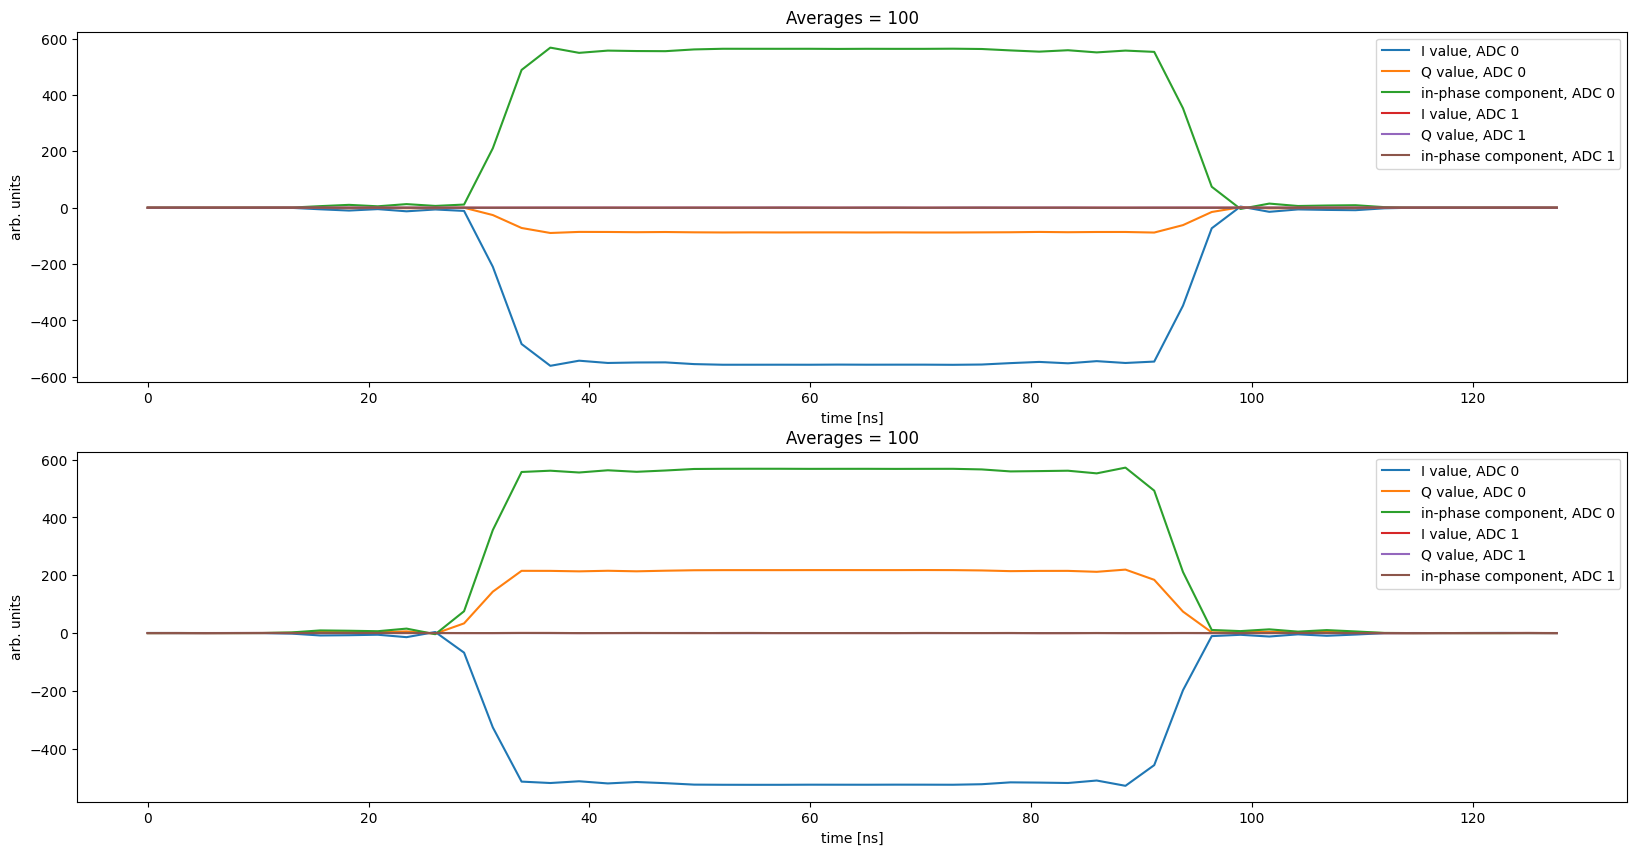

In [162]:
progs = []
config['send_start'] = False
for i, (soc, soccfg) in enumerate(proxies):
    progs.append(LoopbackProgram(soccfg, config))
    
iq_lists = []
for i, (soc, soccfg) in enumerate(proxies):
    iq_lists.append(progs[i].acquire_decimated(soc, progress=True))

fig, axes = plt.subplots(len(iq_lists), 1, figsize=(20,10))
for i, iq_list in enumerate(iq_lists):
    plot = axes[i]
    for ii, iq in enumerate(iq_list):
        t = 1000*progs[0].get_time_axis(ro_index=ii)
        plot.plot(t, iq[0], label="I value, ADC %d"%(config['ro_chs'][ii]))
        plot.plot(t, iq[1], label="Q value, ADC %d"%(config['ro_chs'][ii]))
        plot.plot(t, get_inphase(iq.T), label="in-phase component, ADC %d"%(config['ro_chs'][ii]))
    plot.set_ylabel("arb. units")
    plot.set_xlabel("time [ns]")
    plot.set_title("Averages = " + str(config["soft_avgs"]))
    plot.legend();

### synchronized
Now we run the boards together, and plot the individual pulses (blue for the local loopback, red for the pulse coming from the other board).
Adjust the `leader_delay` to get the pulses aligned the way you want them.

If the boards are well synchronized, the pulses should all lie on top of each other.

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

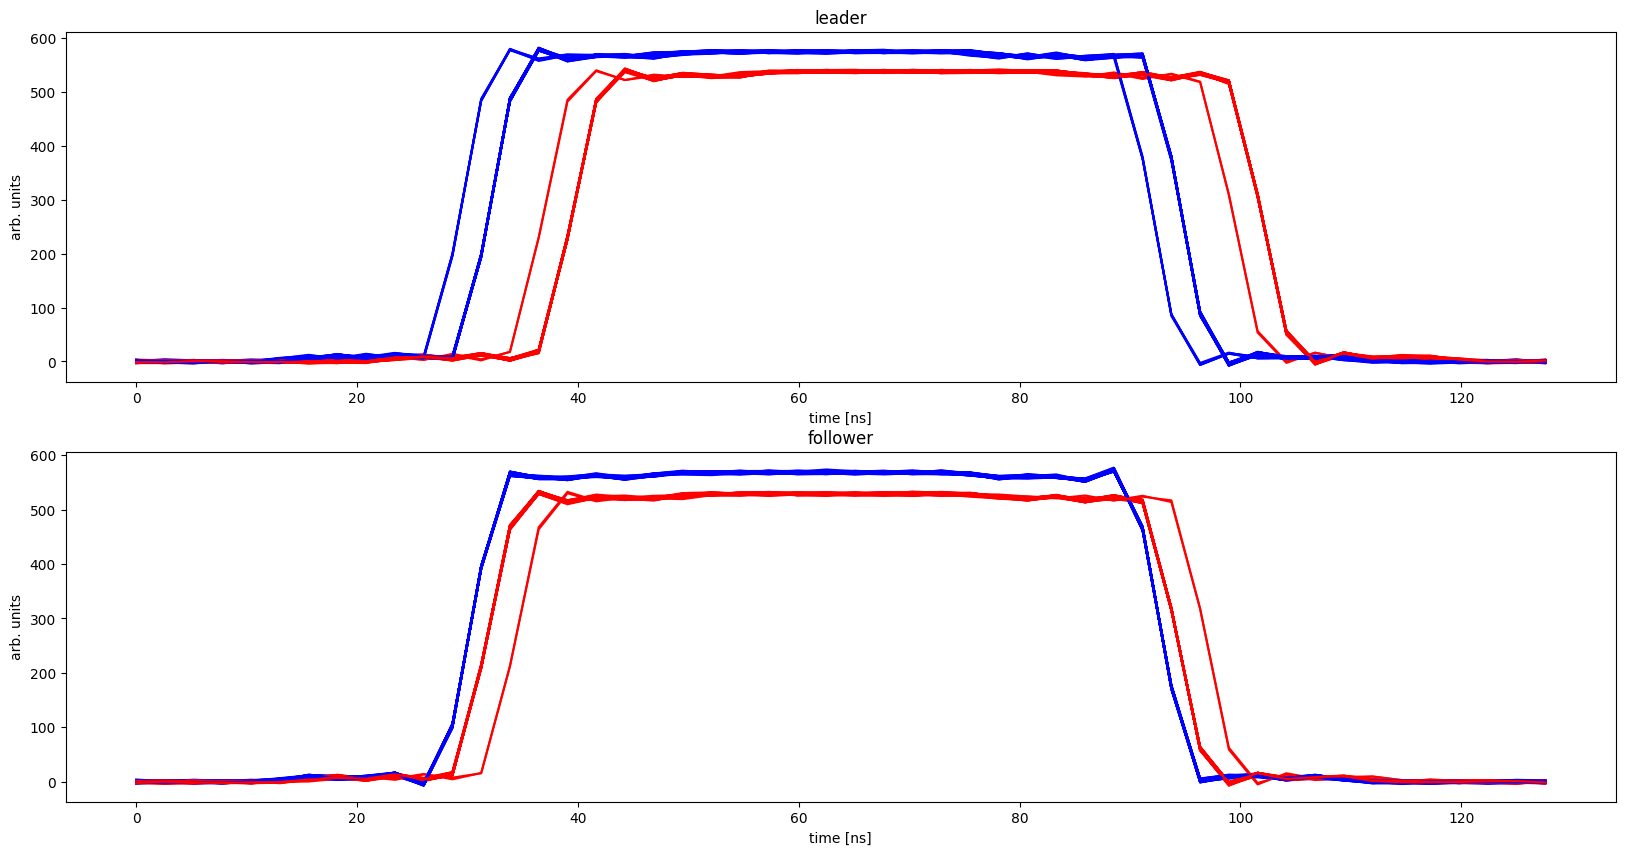

In [221]:
config['leader_delay'] = 14

progs = []
for i, (soc, soccfg) in enumerate(proxies):
    config['send_start'] = (i==0)
    progs.append(LoopbackProgram(soccfg, config))

iq_lists = asyncio.run(run_multi_decimated(loop, proxies, progs, progress=True))

fig, axes = plt.subplots(len(progs), 1, figsize=(20,10))
colors = ['blue', 'red']
for i, prog in enumerate(progs):
    plot = axes[i]
    for iq_list in prog.get_rounds():
        for ii, iq in enumerate(iq_list):
            t = 1000*prog.get_time_axis(ro_index=ii)
            plot.plot(t, get_inphase(iq.T), label="in-phase component, ADC %d"%(config['ro_chs'][ii]),color=colors[ii])
    plot.set_ylabel("arb. units")
    plot.set_xlabel("time [ns]")
    plot.set_title(['leader','follower'][i])
    

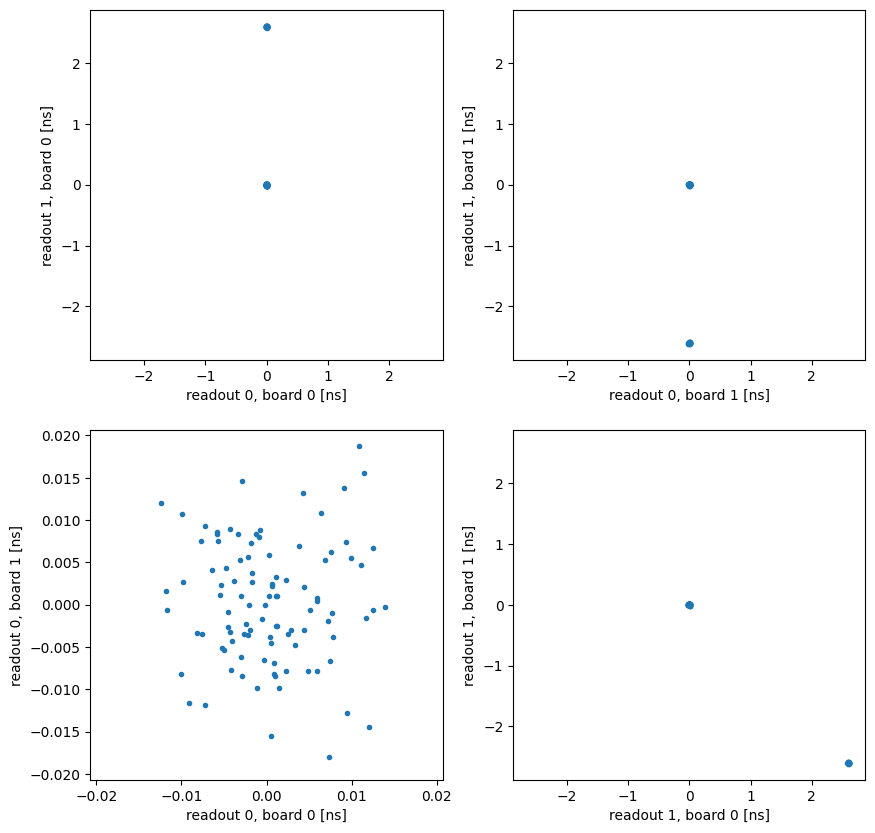

In [217]:
# fit pulse edges
edges = np.array([[[find_edges(get_inphase(iq.T)) for iq in iq_list] for iq_list in prog.get_rounds()] for prog in progs])
# convert to ns
edges *= progs[0].get_time_axis(ro_index=0)[1]*1e3
# use the average of the rising and falling edges as the pulse time
pulsetimes = edges[...,:2].mean(axis=-1)

fig, axes = plt.subplots(2,2,figsize=(10,10))
for iSoc in range(2):
    plot = axes[0, iSoc]
    plot_jitter(plot, pulsetimes[iSoc,:,0], pulsetimes[iSoc,:,1])
    plot.set_xlabel("readout %d, board %d [ns]"%(0, iSoc))
    plot.set_ylabel("readout %d, board %d [ns]"%(1, iSoc))

for iRO in range(2):
    plot = axes[1, iRO]
    plot_jitter(plot, pulsetimes[0,:,iRO], pulsetimes[1,:,iRO])
    plot.set_xlabel("readout %d, board %d [ns]"%(iRO, 0))
    plot.set_ylabel("readout %d, board %d [ns]"%(iRO, 1))

## tProc v2
The start pulse is launched on the leader's tProc dispatcher clock and latched on the follower's tProc core clock; the follower's core then starts the dispatcher.
For this to be jitter-free, the dispatcher clock should be an integer multiple of the core clock. Until now this has not been true in the standard firmware, which has been generating the core clock from the PS clock - but easy to change.

Standard firmware with tProc r23, so you can see the problem for yourself: https://s3df.slac.stanford.edu/people/meeg/qick/tprocv2/2025-05-30_111_tprocv2r23_standard/

Jitter-free, the firmware you really should be using:
https://s3df.slac.stanford.edu/people/meeg/qick/tprocv2/2025-06-05_111_tprocv2r24_standard/

On each board (`qick1` for leader, `qick2` for follower, nameserver running on the same PC as this notebook - you could do this all differently):
```
from qick.pyro import start_server
start_server(ns_host="linux-139028.dhcp.fnal.gov", ns_port=8888, proxy_name="qick1",
             external_clk=True,
             adc_sample_rates={0:3072.0, 2:3072.0},
#              bitfile="/data/fw/2025-05-30_111_tprocv2r23_standard/qick_111.bit"
             bitfile="/data/fw/2025-06-05_111_tprocv2r24_standard/qick_111.bit"
            )
```

It doesn't matter what order you initialize the boards. Since the phase relationship between the tProc clocks is random, it's possible you will be unlucky and the sync pulse will arrive at the follower on the edge of a clock cycle, giving you a random one-tick jitter. If you see this in the results below (it's not common, seems to be less than 10% probability), re-initializing the leader or follower will fix it. (In a system with many boards, this problem scales linearly, since you just need to cycle the followers - not a big deal.)

In [349]:
from qick.pyro import make_proxy
proxies = []
for name in ['qick1', 'qick2']:
    proxies.append(make_proxy(ns_host="localhost", ns_port=8888, proxy_name=name))

for soc, soccfg in proxies:
    print(soccfg)

Pyro.NameServer PYRO:Pyro.NameServer@0.0.0.0:8888
qick1 PYRO:obj_5e0fb20624704ac09041206db2ad0e48@131.225.82.194:39259
qick2 PYRO:obj_b66d92e255084b998c4d27633bf9c0f9@131.225.82.187:36985
Pyro.NameServer PYRO:Pyro.NameServer@0.0.0.0:8888
qick1 PYRO:obj_5e0fb20624704ac09041206db2ad0e48@131.225.82.194:39259
qick2 PYRO:obj_b66d92e255084b998c4d27633bf9c0f9@131.225.82.187:36985
QICK running on ZCU111, software version 0.2.340

Firmware configuration (built Thu Jun  5 18:06:41 2025):

	Global clocks (MHz): tProc dispatcher timing 384.000, RF reference 204.800
	Groups of related clocks: [tProc core clock, tProc timing clock, DAC tile 0, DAC tile 1], [ADC tile 0, ADC tile 2]

	8 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (10.667 us)
		fs=6144.000 Msps, fabric=384.000 MHz, 32-bit DDS, range=6144.000 MHz
		DAC tile 0, blk 0 is DAC228_T0_CH0 or RF board output 0
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (10.667 us)
		fs=6144.000 Msps, fabric=384

In [352]:
# the main program class
from qick.asm_v2 import AveragerProgramV2
# for defining sweeps
from qick.asm_v2 import QickSpan, QickSweep1D

GEN_CHS = [7, 6]
RO_CHS = [0, 1]
TRIG_TIME = 0.35 # us
FREQ = 500

In [353]:
class LoopbackProgramV2(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_chs = cfg['ro_chs']
        gen_chs = cfg['gen_chs']
        for gen_ch in gen_chs:
            self.declare_gen(ch=gen_ch, nqz=1)
            # the minimum length for a waveform (i.e. either ramp of a flat-top) is 5 fabric ticks (80 DAC samples)
            # my time resolution suffers if the ramp is too slow, so I make a custom envelope
            # the ramp is only 32 samples at the start+end of the array, the middle is flat
            maxv = self.get_maxv(gen_ch)
            idata = np.ones(10*16, dtype=np.int32)*maxv
            idata[:cfg['ramp_nsamp']] = np.linspace(0, maxv, cfg['ramp_nsamp'], dtype=np.int32)
            idata[:-cfg['ramp_nsamp']-1:-1] = np.linspace(0, maxv, cfg['ramp_nsamp'], dtype=np.int32)
            qdata = np.zeros(10*16, dtype=np.int32)
            self.add_envelope(ch=gen_ch, name="ramp", idata=idata, qdata=qdata)

        self.add_pulse(ch=gen_chs,
                      name="mypulse",
                      ro_ch=ro_chs[0],
                      # style="const",
                      style="flat_top",
                      envelope="ramp",
                      freq=cfg['freq'],
                      length=cfg['pulse_len'],
                      phase=cfg['gen_phase'],
                      gain=cfg['gen_gain'],
                      )

        for ro_ch in ro_chs:
            self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        self.add_readoutconfig(ch=ro_chs,
                              name="myro",
                              freq=cfg['freq'],
                              gen_ch=gen_chs[0])

        for ro_ch in ro_chs:
            self.send_readoutconfig(ch=ro_ch,
                                   name="myro",
                                   t=0)
        if cfg['send_start']:
            self.delay(0.5)  # give processor some time to set registers
            self.trigger(pins=[0], t=0) # output a pulse on PMOD0_0, to trigger the follower
            self.delay(cfg['leader_delay']) # give follower time to catch up
        if cfg['follower_delay'] > 0:
            self.delay(cfg['follower_delay'])
                    
    def _body(self, cfg):
        self.delay(10)
        for gen_ch in cfg['gen_chs']:
            self.pulse(ch=gen_ch, name="mypulse", t=0)
        self.trigger(ros=cfg['ro_chs'], t=cfg['trig_time'])
        
config = \
{
    'gen_chs': GEN_CHS,
    'ro_chs': RO_CHS,
    'freq': FREQ,
    'trig_time': TRIG_TIME,
    'ro_len': 0.2,
    'pulse_len': 0.05,
    'ramp_nsamp': 32, # [DAC samples]
    'gen_gain': 1.0,
    'gen_phase': 0.0,
    'send_start': False,
    'leader_delay': 0.05, # [us]
    'follower_delay': 0, # [us]
}


### one board at a time

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

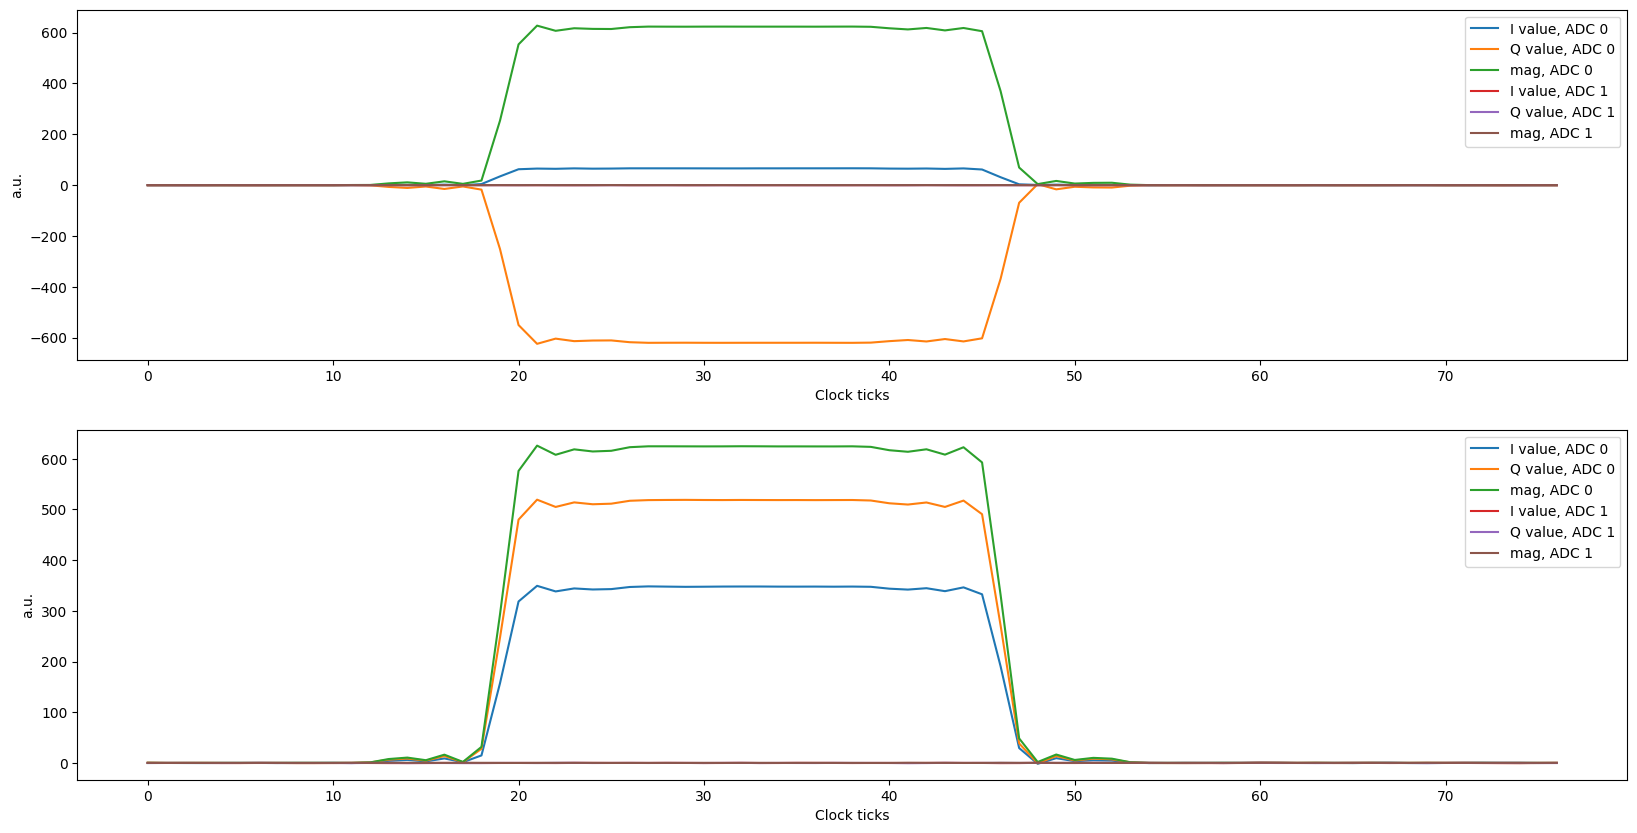

In [357]:
progs = []
config['send_start'] = False
for i, (soc, soccfg) in enumerate(proxies):
    progs.append(LoopbackProgramV2(soccfg, reps=1, final_delay=0.5, cfg=config))
    
iq_lists = []
for i, (soc, soccfg) in enumerate(proxies):
    iq_lists.append(progs[i].acquire_decimated(soc, progress=True, rounds=100))

fig, axes = plt.subplots(len(iq_lists), 1, figsize=(20,10))
for i, iq_list in enumerate(iq_lists):
    plot = axes[i]
    for ii, iq in enumerate(iq_list):
        plot.plot(iq[:,0], label="I value, ADC %d"%(config['ro_chs'][ii]))
        plot.plot(iq[:,1], label="Q value, ADC %d"%(config['ro_chs'][ii]))
        plot.plot(np.abs(iq.dot([1,1j])), label="mag, ADC %d"%(config['ro_chs'][ii]))
    plot.set_ylabel("a.u.")
    plot.set_xlabel("Clock ticks")
    plot.legend();

### synchronized

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

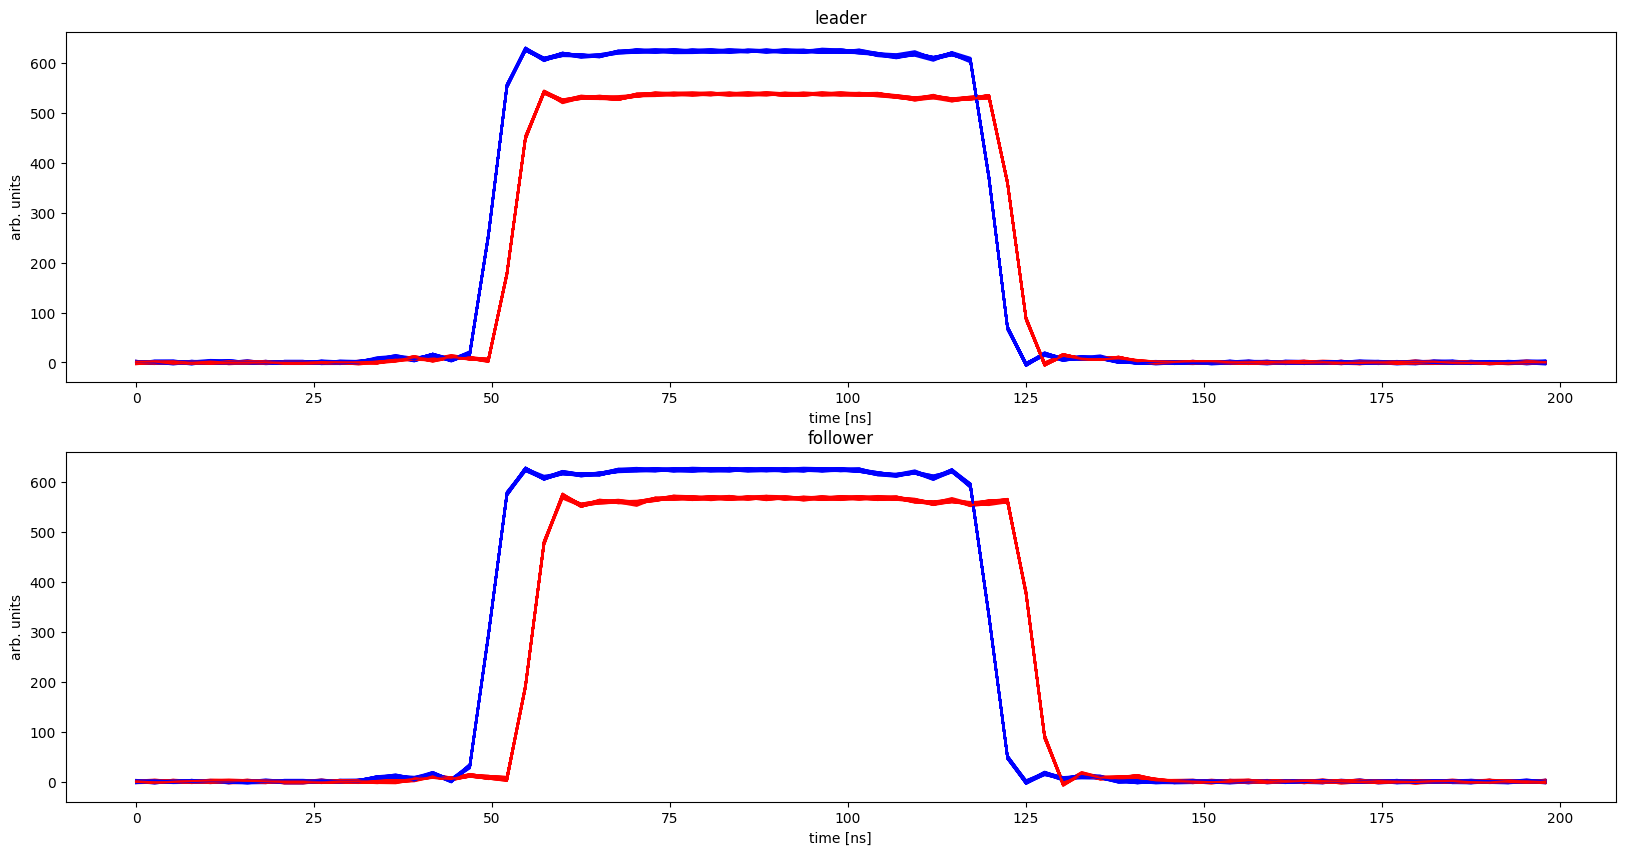

In [355]:
config['leader_delay'] = soccfg.cycles2us(22)

progs = []
for i, (soc, soccfg) in enumerate(proxies):
    config['send_start'] = (i==0)
    progs.append(LoopbackProgramV2(soccfg, reps=1, final_delay=0.5, cfg=config))

iq_lists = asyncio.run(run_multi_decimated(loop, proxies, progs, rounds=100))

fig, axes = plt.subplots(len(progs), 1, figsize=(20,10))
colors = ['blue', 'red']
for i, prog in enumerate(progs):
    plot = axes[i]
    for iq_list in prog.get_rounds():
        for ii, iq in enumerate(iq_list):
            t = 1000*prog.get_time_axis(ro_index=ii)
            plot.plot(t, get_inphase(iq), label="in-phase component, ADC %d"%(config['ro_chs'][ii]),color=colors[ii])
    plot.set_ylabel("arb. units")
    plot.set_xlabel("time [ns]")
    plot.set_title(['leader','follower'][i])

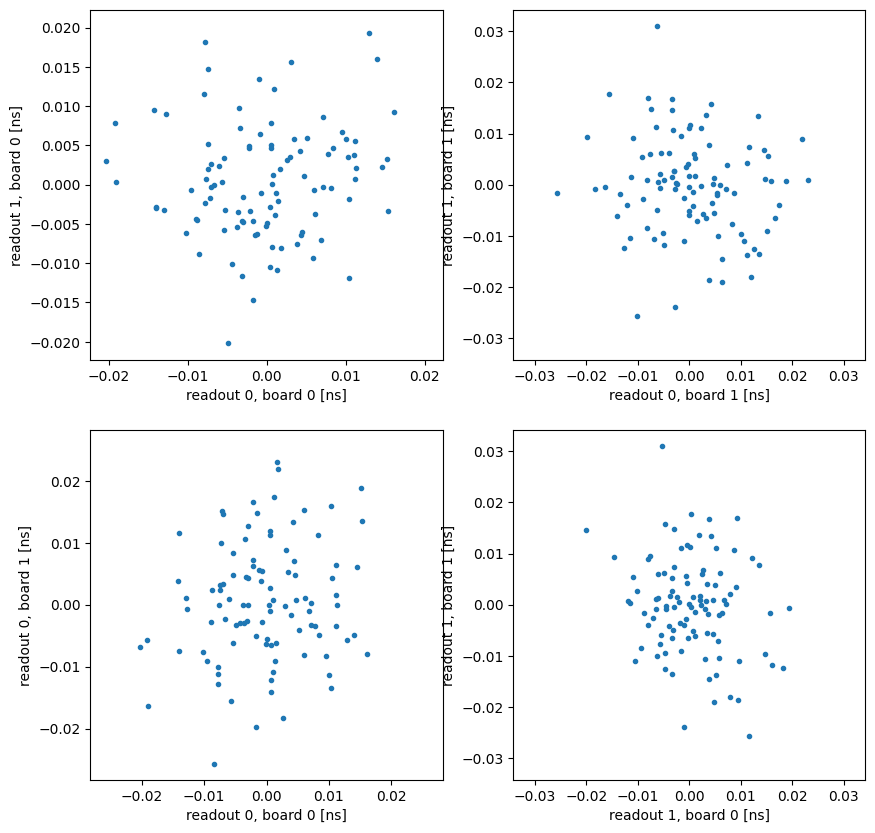

In [356]:
# fit pulse edges
edges = np.array([[[find_edges(get_inphase(iq)) for iq in iq_list] for iq_list in prog.get_rounds()] for prog in progs])
# convert to ns
edges *= progs[0].get_time_axis(ro_index=0)[1]*1e3
# use the average of the rising and falling edges as the pulse time
pulsetimes = edges[...,:2].mean(axis=-1)

fig, axes = plt.subplots(2,2,figsize=(10,10))
for iSoc in range(2):
    plot = axes[0, iSoc]
    plot_jitter(plot, pulsetimes[iSoc,:,0], pulsetimes[iSoc,:,1])
    plot.set_xlabel("readout %d, board %d [ns]"%(0, iSoc))
    plot.set_ylabel("readout %d, board %d [ns]"%(1, iSoc))

for iRO in range(2):
    plot = axes[1, iRO]
    plot_jitter(plot, pulsetimes[0,:,iRO], pulsetimes[1,:,iRO])
    plot.set_xlabel("readout %d, board %d [ns]"%(iRO, 0))
    plot.set_ylabel("readout %d, board %d [ns]"%(iRO, 1))

## scratchwork

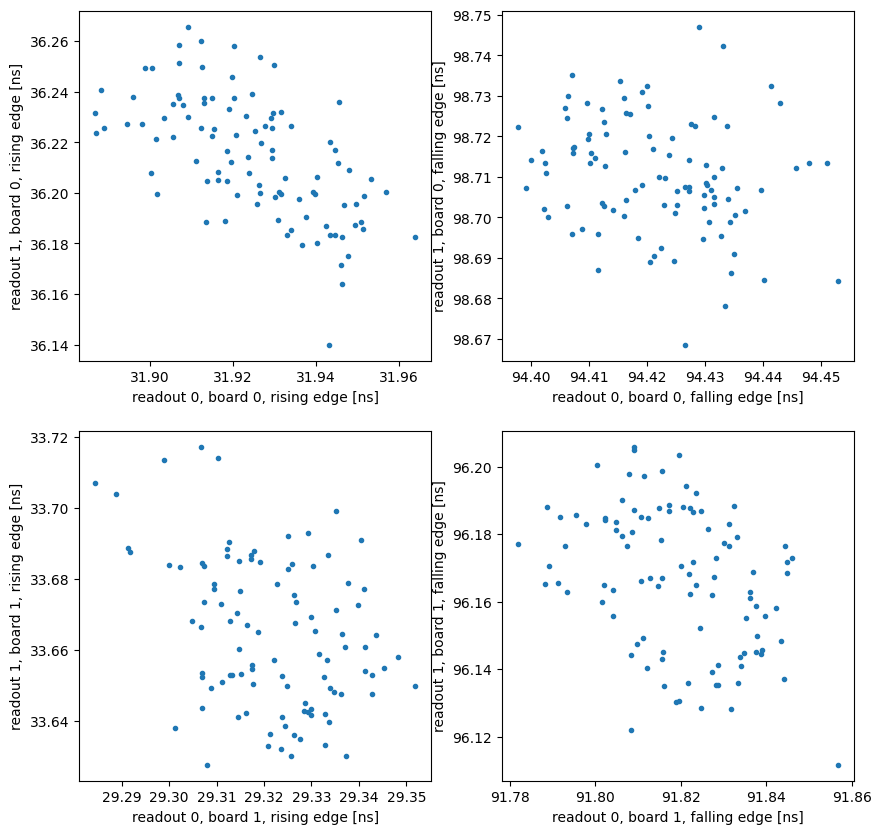

In [149]:
fig, axes = plt.subplots(2,2,figsize=(10,10))
edgename = ['rising','falling']
for iSoc in range(2):
    for iEdge in range(2):
        plot = axes[iSoc, iEdge]
        plot.plot(edges[iSoc,:,0,iEdge], edges[iSoc,:,1,iEdge], '.')
        plot.set_xlabel("readout %d, board %d, %s edge [ns]"%(0, iSoc, edgename[iEdge]))
        plot.set_ylabel("readout %d, board %d, %s edge [ns]"%(1, iSoc, edgename[iEdge]))


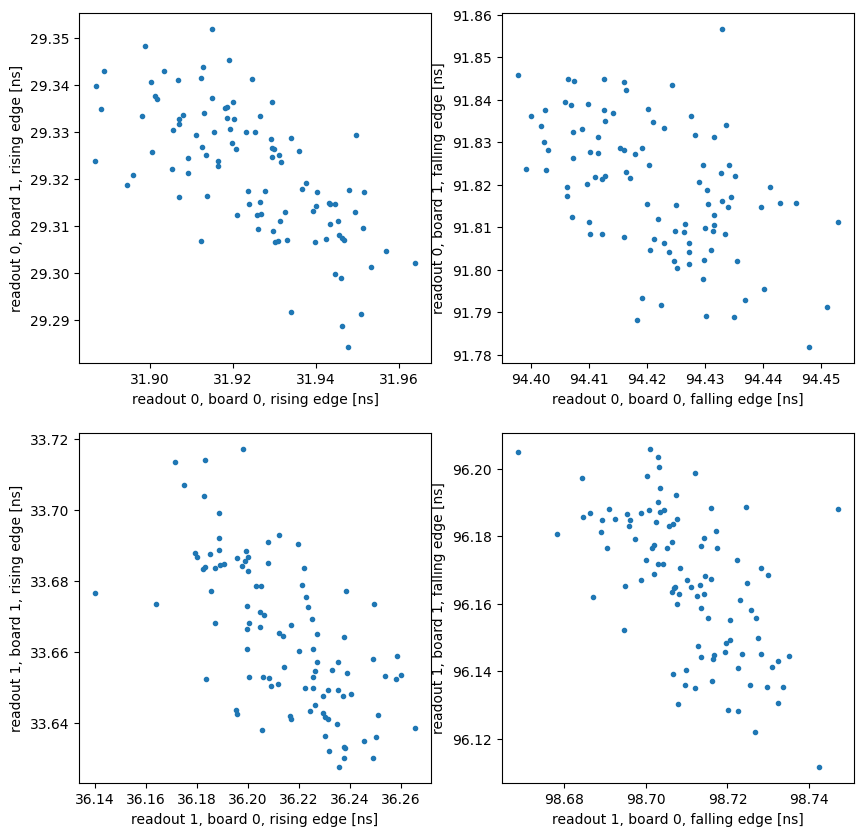

In [150]:
fig, axes = plt.subplots(2,2,figsize=(10,10))
edgename = ['rising','falling']
for iRO in range(2):
    for iEdge in range(2):
        plot = axes[iRO, iEdge]
        plot.plot(edges[0,:,iRO,iEdge], edges[1,:,iRO,iEdge], '.')
        plot.set_xlabel("readout %d, board %d, %s edge [ns]"%(iRO, 0, edgename[iEdge]))
        plot.set_ylabel("readout %d, board %d, %s edge [ns]"%(iRO, 1, edgename[iEdge]))
        

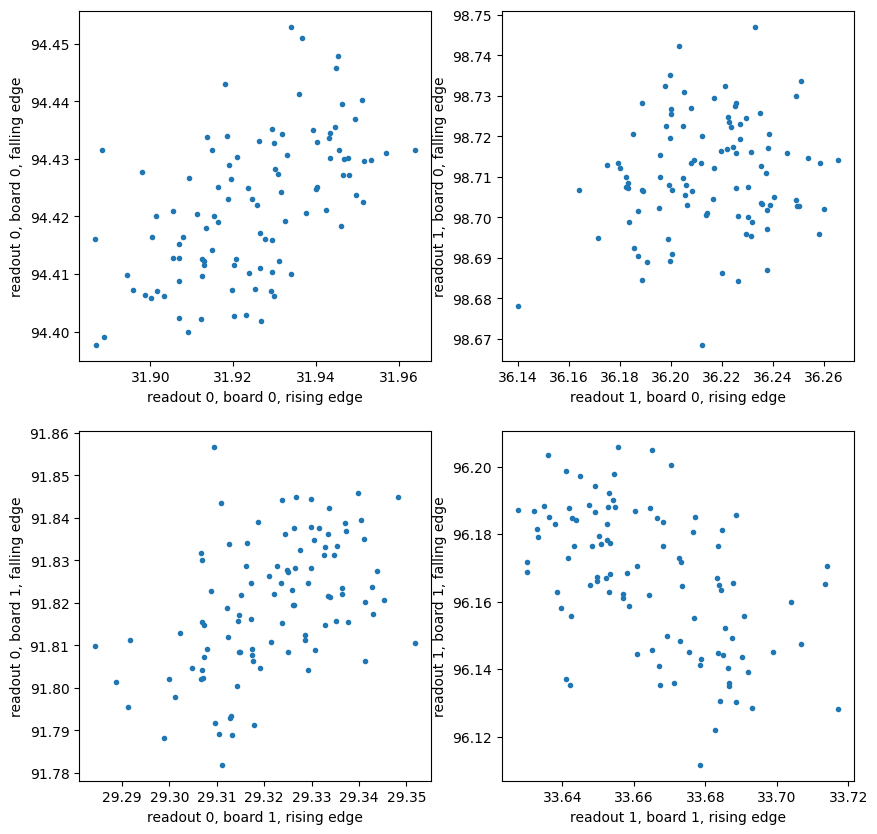

In [151]:
fig, axes = plt.subplots(2,2,figsize=(10,10))
for iSoc in range(2):
    for iRO in range(2):
        plot = axes[iSoc, iRO]
        plot.plot(edges[iSoc,:,iRO,0], edges[iSoc,:,iRO,1], '.')
        plot.set_xlabel("readout %d, board %d, %s edge"%(iRO, iSoc, edgename[0]))
        plot.set_ylabel("readout %d, board %d, %s edge"%(iRO, iSoc, edgename[1]))
